**Importing Libraries**

In [2]:
import numpy as np, pandas as pd

!pip install talos

import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 2.3 MB/s 
     |████████████████████████████████| 52 kB 871 kB/s 
     |████████████████████████████████| 5.4 MB 28.0 MB/s 
     |████████████████████████████████| 26.4 MB 1.8 MB/s 
     |████████████████████████████████| 1.6 MB 52.2 MB/s 
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41607 sha256=1f3d45055062e33eb7c12a643793ec8eed871b14de4ea3671b5f3d54c86b6b8d
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=528103ececd2b1bf44e7463f88b6e82ebbcdcde8f4b7fdaf5d5c2868d846412d
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built chances sklearn


[nltk_data] Downloading package wordnet to /root/nltk_data...


**Importing Data**

In [4]:
url = 'https://raw.githubusercontent.com/shaunak09vb/Toxic-Comment-Classifier-using-Deep-Learning/main/Data/train.csv'
train = pd.read_csv(url)

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
url = 'https://raw.githubusercontent.com/shaunak09vb/Toxic-Comment-Classifier-using-Deep-Learning/main/Data/test.csv'
test = pd.read_csv(url)

In [7]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


**Data Exploration**

In [8]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [9]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [10]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

**Data Pre-processing**

Text Normalization

Removing Characters in between Text

Removing Repeated Characters

Converting data to lower-case

Removing Numbers from the data

Remove Punctuation

Remove Whitespaces

Removing spaces in between words

Removing "\n"

Remove Non-english characters 

In [11]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}

In [12]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 

Cleaning Training Data

In [13]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

Cleaning Test Data

In [14]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'this is a university ip address just fyi '

**Lemmatization**

In [15]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [16]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [17]:
wordnet_lemmatizer = WordNetLemmatizer()

In [18]:
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 

In [19]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [ ]:
Lemmatizing Training Data

In [20]:
lemmatized_train_data = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    lemmatized_train_data.append(lemma(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

Lemmatizing Test Data

In [21]:
lemmatized_train_data[152458]

'i agree with you about graemel s intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wp rr three revert rule notice board post by report the revert nazi graemel ha show himself herself to be a revert nazi this be unacceptable on a site that be make by it s user and not it s admins if you feel you have be unjustly revert more than time over a hour period please report him her to the three revert noticeboard wp rr it be time to take back what be ours'

In [22]:
lemmatized_test_data = [] 

for line in tqdm_notebook(comments_test, total=len(comments_test)): 
    lemmatized_test_data.append(lemma(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

**Stopwords Removal**

In [23]:
stopword_list=STOP_WORDS

In [24]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [25]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [26]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


Checking for other words that we may need in STOP_WORDS

In [27]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip())

In [28]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [29]:
len(potential_stopwords)

159571

Combining all the sentences in the list into a single string

In [30]:
def string_combine_a(stopword):
  final_a=""
  for item in range(39893):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(39893,79785):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(79785,119678):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(119678,159571):
    final_d=final_d+" "+stopword[item]
  return final_d

In [31]:
total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

Counting the number of words in each of the 4 strings

In [32]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [33]:
total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

Converting Dictionaries to Dataframe

In [34]:
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

Getting Dataframe output in descending order

In [36]:
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

Looking for common terms in all top 50 dataframes

In [37]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))


In [38]:
print(common_potential_stopwords)

['question', 'good', 'reference', 'know', 'point', 'fact', 'fuck', 'block', 'work', 'try', 'delete', 'read', 'like', 'talk', 'new', 'thank', 'look', 'article', 'people', 'use', 'think', 'section', 'time', 'list', 'way', 'link', 'editor', 'user', 'remove', 'change', 'image', 'deletion', 'need', 'write', 'help', 'thing', 'comment', 'source', 'don', 'add', 'want', 'wikipedia', 'find', 'mean', 'edit', 'page', 'information', 'doe']


Retaining certain words and removing others from the above list

In [39]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']


Adding above retrived words into the stopwords list

In [ ]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Removing Stopwords from Training Data

In [41]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip()) 

In [42]:
processed_train_data = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    processed_train_data.append(remove_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [43]:
processed_train_data[152458]

'agree graemel intention revert nazi protect report revert rule notice board post report revert nazi graemel revert nazi unacceptable site admins feel unjustly revert hour period report revert noticeboard'

Removing Stopwords from Test Data

In [44]:
processed_test_data = [] 

for line in tqdm_notebook(lemmatized_test_data, total=153164): 
    processed_test_data.append(remove_stopwords(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Model Building**

In [45]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

Tokenization

In [46]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)


In [47]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))


Words in Vocabulary:  148917


Padding

In [48]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')


In [49]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  116   578    11 32199   239   192    11 32199   239    90    11   579
    11   116   366   578     1  1082   116   338  5356   116   119    11
   387   269   366   578    11     1  1341   116    11   387     2    32
   116   578   192   116   172    46    84   579   116   578    11     2
   488   105    10  1087   403  1073    11  2401   489    36   116    11
   192   407   366     9   255   192   242   150   109    18    19    29
   172    77    19     3   257  4540     4    11 32199   239   192    11
 32199   239    90   171   387   312    68   579    34    44    77   423
  1550    34   171     8   579  1268    77  1638   134    10   134  4671
   134    94    44   565  1255    17    77  1338   118   134  1577    77
  1134     4   507    77   434    31   171    68    34   168  2207   449
    31   315  1529    70   172   236   150   116    31    31    11    77
    31   116    11    77    31    77    31   192   171    46    84   579
     4    31   171   192    

In [50]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [51]:
X_t = X_t[indices]
labels = y[indices]

**Splitting data into Training and Validation Set**

In [52]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [53]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12257  1289  6797   384  6311  1121]
validation:  [3037  306 1652   94 1566  284]


**Importing Fast Text**

In [54]:
embeddings_index_fasttext = {}
f = open('/content/drive/MyDrive/Colab Notebooks/comment_toxicity_folder/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [55]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print(" Completed!")

 Completed!


**Creating Model**

**Talos Grid Search for LSTM Model **

In [56]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  
  x = GlobalMaxPool1D()(x)
  
  x = Dropout(params['dropout'])(x)
  
  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [57]:
p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [58]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/18 [00:00<?, ?it/s]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 10ms/step - loss: 0.0643 - accuracy: 0.9242 - val_loss: 0.0521 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 40s 10ms/step - loss: 0.0500 - accuracy: 0.9852 - val_loss: 0.0473 - val_accuracy: 0.9923


  6%|▌         | 1/18 [02:25<41:13, 145.53s/it]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0681 - accuracy: 0.8887 - val_loss: 0.0520 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0521 - accuracy: 0.9809 - val_loss: 0.0487 - val_accuracy: 0.9940


 11%|█         | 2/18 [04:50<38:41, 145.07s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0642 - accuracy: 0.9723 - val_loss: 0.0515 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0499 - accuracy: 0.9910 - val_loss: 0.0472 - val_accuracy: 0.9938


 17%|█▋        | 3/18 [06:14<29:21, 117.43s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0660 - accuracy: 0.9438 - val_loss: 0.0501 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0518 - accuracy: 0.9895 - val_loss: 0.0480 - val_accuracy: 0.9940


 22%|██▏       | 4/18 [07:39<24:22, 104.49s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0635 - accuracy: 0.9280 - val_loss: 0.0492 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0494 - accuracy: 0.9810 - val_loss: 0.0471 - val_accuracy: 0.9940


 28%|██▊       | 5/18 [09:04<21:05, 97.34s/it] 

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0682 - accuracy: 0.8931 - val_loss: 0.0516 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0518 - accuracy: 0.9868 - val_loss: 0.0480 - val_accuracy: 0.9940


 33%|███▎      | 6/18 [10:25<18:24, 92.06s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0622 - accuracy: 0.9541 - val_loss: 0.0500 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0497 - accuracy: 0.9787 - val_loss: 0.0480 - val_accuracy: 0.9930


 39%|███▉      | 7/18 [11:52<16:34, 90.42s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0669 - accuracy: 0.9118 - val_loss: 0.0516 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0518 - accuracy: 0.9856 - val_loss: 0.0482 - val_accuracy: 0.9940


 44%|████▍     | 8/18 [13:18<14:48, 88.84s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0620 - accuracy: 0.9421 - val_loss: 0.0493 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0490 - accuracy: 0.9835 - val_loss: 0.0471 - val_accuracy: 0.9933


 50%|█████     | 9/18 [14:46<13:16, 88.53s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0667 - accuracy: 0.8624 - val_loss: 0.0504 - val_accuracy: 0.9932
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0511 - accuracy: 0.9731 - val_loss: 0.0477 - val_accuracy: 0.9928


 56%|█████▌    | 10/18 [17:11<14:07, 105.88s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0620 - accuracy: 0.9374 - val_loss: 0.0489 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0487 - accuracy: 0.9816 - val_loss: 0.0470 - val_accuracy: 0.9905


 61%|██████    | 11/18 [18:43<11:51, 101.64s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0645 - accuracy: 0.9139 - val_loss: 0.0510 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0511 - accuracy: 0.9771 - val_loss: 0.0480 - val_accuracy: 0.9940


 67%|██████▋   | 12/18 [21:07<11:28, 114.77s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0626 - accuracy: 0.8916 - val_loss: 0.0493 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0494 - accuracy: 0.9852 - val_loss: 0.0467 - val_accuracy: 0.9939


 72%|███████▏  | 13/18 [23:32<10:19, 123.89s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0666 - accuracy: 0.8914 - val_loss: 0.0505 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0517 - accuracy: 0.9814 - val_loss: 0.0476 - val_accuracy: 0.9940


 78%|███████▊  | 14/18 [25:02<07:34, 113.59s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0620 - accuracy: 0.9470 - val_loss: 0.0493 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0494 - accuracy: 0.9917 - val_loss: 0.0470 - val_accuracy: 0.9940


 83%|████████▎ | 15/18 [26:31<05:18, 106.30s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0641 - accuracy: 0.9314 - val_loss: 0.0499 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0507 - accuracy: 0.9808 - val_loss: 0.0470 - val_accuracy: 0.9940


 89%|████████▉ | 16/18 [28:56<03:55, 117.86s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0597 - accuracy: 0.9513 - val_loss: 0.0492 - val_accuracy: 0.9935
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0479 - accuracy: 0.9880 - val_loss: 0.0464 - val_accuracy: 0.9911


 94%|█████████▍| 17/18 [31:21<02:05, 125.94s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0652 - accuracy: 0.9491 - val_loss: 0.0496 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0506 - accuracy: 0.9770 - val_loss: 0.0471 - val_accuracy: 0.9938


100%|██████████| 18/18 [32:50<00:00, 109.49s/it]


In [59]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

1

In [60]:
analyze_object = talos.Analyze(scan_results)

In [61]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])


array([['sigmoid', '11/19/22-131854', 32, 40, 0.1, 'relu',
        88.60635137557983, 'adam', 60, '11/19/22-132023', 2, 2, 0],
       ['sigmoid', '11/19/22-130006', 32, 40, 0.2, 'relu',
        83.92966103553772, 'adam', 40, '11/19/22-130130', 2, 2, 1],
       ['sigmoid', '11/19/22-130545', 32, 30, 0.2, 'relu',
        84.72499823570251, 'adam', 50, '11/19/22-130709', 2, 2, 2],
       ['sigmoid', '11/19/22-125617', 32, 30, 0.2, 'relu',
        143.93981456756592, 'adam', 40, '11/19/22-125841', 2, 2, 3],
       ['sigmoid', '11/19/22-132024', 32, 40, 0.2, 'relu',
        143.92196202278137, 'adam', 60, '11/19/22-132247', 2, 2, 4],
       ['sigmoid', '11/19/22-131235', 32, 50, 0.2, 'relu',
        144.00925302505493, 'adam', 50, '11/19/22-131459', 2, 2, 5],
       ['sigmoid', '11/19/22-131724', 32, 30, 0.2, 'relu',
        89.00064373016357, 'adam', 60, '11/19/22-131853', 2, 2, 6],
       ['sigmoid', '11/19/22-130131', 32, 50, 0.1, 'relu',
        83.91309070587158, 'adam', 40, '11/19/22-

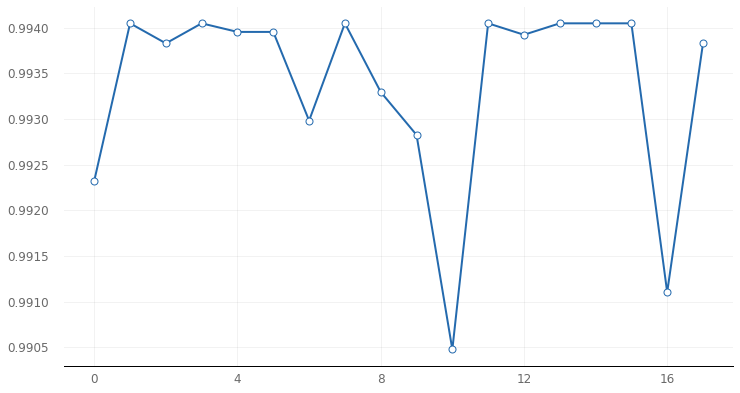

In [62]:
analyze_object.plot_line('val_accuracy')


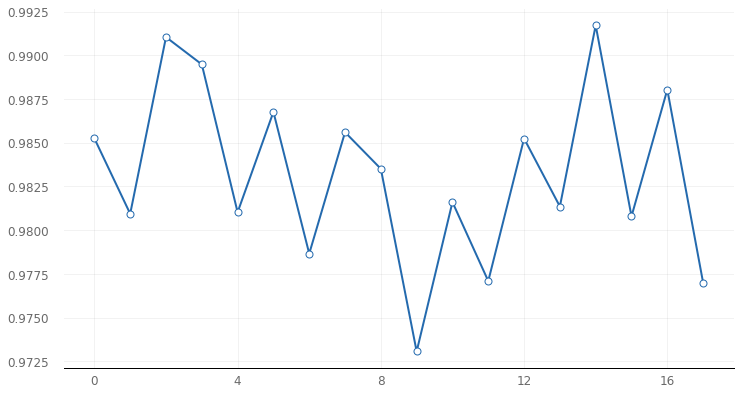

In [63]:
analyze_object.plot_line('accuracy')

**Training Model with best parameters**

In [64]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [65]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [66]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)


In [67]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [68]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44675400  
                                                                 
 lstm_layer (LSTM)           (None, 200, 40)           54560     
                                                                 
 global_max_pooling1d (Globa  (None, 40)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                             

In [69]:
model_info_1=model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))


Epoch 1/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0663 - accuracy: 0.9394 - val_loss: 0.0508 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0512 - accuracy: 0.9871 - val_loss: 0.0502 - val_accuracy: 0.9940


**Plotting Graphs**

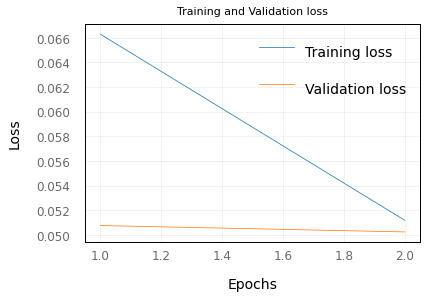

In [70]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

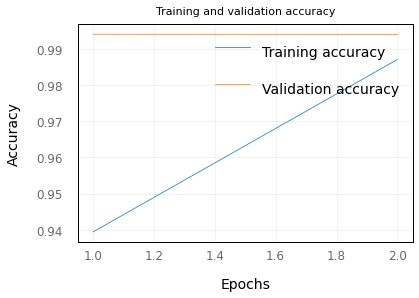

In [71]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [84]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [85]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [86]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.0, Recall:0.0, Accuracy:0.0


**Saving the Model**

In [72]:
model_1.save(filepath="/content/drive/MyDrive/Colab Notebooks/comment_toxicity_folder/toxicity.h5")

**Loading Saved Model**

In [ ]:
toxicity_model = keras.models.load_model(filepath="/content/drive/MyDrive/Colab Notebooks/comment_toxicity_folder/toxicity.h5")


**Testing the Created Model**

In [74]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = toxicity_model.predict(new_string) 
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [75]:
toxicity_level('go jump off a bridge jerk')


1/1 [==============================] - 0s 424ms/step
Toxicity levels for 'go jump off a bridge jerk':
Toxic:         66%
Severe Toxic:  0%
Obscene:       31%
Threat:        1%
Insult:        26%
Identity Hate: 1%



In [76]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 30.1 MB/s 
     |████████████████████████████████| 106 kB 71.4 MB/s 
     |████████████████████████████████| 213 kB 65.9 MB/s 
     |████████████████████████████████| 84 kB 4.5 MB/s 
     |████████████████████████████████| 272 kB 63.7 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 
     |████████████████████████████████| 55 kB 4.6 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 2.3 MB 59.7 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 64 kB 2.9 MB/s 
     |████████████████████████████████| 80 kB 10.5 MB/s 
     |████████████████████████████████| 68 kB 8.1 MB/s 
     |████████████████████████████████| 68 kB 4.4 MB/s 
     |████████████████████████████████| 68 kB 7.8 MB/s 
     |████████████████████████████████| 46 kB 4.9

In [77]:
import tensorflow as tf
import gradio as gr
import pickle

In [83]:
def make_prediction(input_comment):

    input_comment = clean_text(input_comment)
    input_comment = input_comment.split(" ")

    sequences = tokenizer.texts_to_sequences(input_comment)
    sequences = [[item for sublist in sequences for item in sublist]]

    padded_data = pad_sequences(sequences, maxlen=200)
    result = toxicity_model.predict(padded_data, len(padded_data), verbose=1)

    return \
        {
            "Toxic": str(result[0][0]),
            "Very Toxic": str(result[0][1]),
            "Obscene": str(result[0][2]),
            "Threat": str(result[0][3]),
            "Insult": str(result[0][4]),
            "Hate": str(result[0][5]),
            "Neutral": str(result[0][6])
        }


comment = gr.inputs.Textbox(lines=20, placeholder="Enter your comment!!")

title = "Toxic Comment Classifier"
description = "This application uses a Long Short-Term Memory (LSTM) Recurrent Neural Network (RNN) " \
              "model to predict the inappropriateness of a comment"

gr.Interface(fn=make_prediction,
             inputs=comment,
             outputs="label",
             title=title,
             description=description,
             server_name="0.0.0.0",
             server_port=8080).launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>